<h1>Stock Movement Analysis</h1>

In [1]:
# Import libraries
import praw
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

<h1>Scraping Data from Reddit</h1>

In [2]:
# Reddit API setup
reddit = praw.Reddit(client_id='qYpQlKVNOTtLbGIfTFHbPw',
                     client_secret='TwP8aFUtvDZDF3ZGQrBF9Od1-_smig',
                     user_agent='Stock Market Analysis')
    
# Scrape posts from a subreddit 
subreddit = reddit.subreddit("wallstreetbets")
posts = []

for post in subreddit.hot(limit=100):  # Scrape the top 100 posts
    posts.append([post.title, post.selftext])

# Convert to DataFrame
data = pd.DataFrame(posts, columns=["Title", "Body"])
data["Content"] = data["Title"] + " " + data["Body"]
data.head()

,Title,Body,Content
0,"What Are Your Moves Tomorrow, December 04, 2024",This post contains content not supported on ol...,"What Are Your Moves Tomorrow, December 04, 202..."
1,Weekly Earnings thread 12/2 - 12/6,,Weekly Earnings thread 12/2 - 12/6
2,"Collecting unemployment, sitting here between ...",LUNR cost basis 14.73\nACHR cost basis 7.15\n\...,"Collecting unemployment, sitting here between ..."
3,Is this how it ends? 1k to 1M back to 20k trad...,Yes. First of all I am alive. Secondly as many...,Is this how it ends? 1k to 1M back to 20k trad...
4,I'm fucked,,I'm fucked


<h1>Data Cleaning and Processing</h1>

In [3]:
# Clean and preprocess data
import re

def clean_text(text):
    text = re.sub(r'\n', ' ', text)  # Remove line breaks
    text = re.sub(r'https?://\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = text.lower()  # Convert to lowercase
    return text

data["Cleaned_Content"] = data["Content"].apply(clean_text)
data = data.dropna(subset=["Cleaned_Content"])  # Drop rows with missing content
data.head()

,Title,Body,Content,Cleaned_Content
0,"What Are Your Moves Tomorrow, December 04, 2024",This post contains content not supported on ol...,"What Are Your Moves Tomorrow, December 04, 202...",what are your moves tomorrow december this p...
1,Weekly Earnings thread 12/2 - 12/6,,Weekly Earnings thread 12/2 - 12/6,weekly earnings thread
2,"Collecting unemployment, sitting here between ...",LUNR cost basis 14.73\nACHR cost basis 7.15\n\...,"Collecting unemployment, sitting here between ...",collecting unemployment sitting here between m...
3,Is this how it ends? 1k to 1M back to 20k trad...,Yes. First of all I am alive. Secondly as many...,Is this how it ends? 1k to 1M back to 20k trad...,is this how it ends k to m back to k trading k...
4,I'm fucked,,I'm fucked,im fucked


<h1>Sentiment Analysis</h1>

In [4]:
# Calculate sentiment polarity
data["Sentiment_Polarity"] = data["Cleaned_Content"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Classify sentiment (Positive: 1, Neutral: 0, Negative: -1)
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 1
    elif polarity < -0.1:
        return -1
    else:
        return 0

data["Sentiment_Label"] = data["Sentiment_Polarity"].apply(classify_sentiment)
data.head()

,Title,Body,Content,Cleaned_Content,Sentiment_Polarity,Sentiment_Label
0,"What Are Your Moves Tomorrow, December 04, 2024",This post contains content not supported on ol...,"What Are Your Moves Tomorrow, December 04, 202...",what are your moves tomorrow december this p...,0.225000,1
1,Weekly Earnings thread 12/2 - 12/6,,Weekly Earnings thread 12/2 - 12/6,weekly earnings thread,0.000000,0
2,"Collecting unemployment, sitting here between ...",LUNR cost basis 14.73\nACHR cost basis 7.15\n\...,"Collecting unemployment, sitting here between ...",collecting unemployment sitting here between m...,-0.251852,-1
3,Is this how it ends? 1k to 1M back to 20k trad...,Yes. First of all I am alive. Secondly as many...,Is this how it ends? 1k to 1M back to 20k trad...,is this how it ends k to m back to k trading k...,0.150000,1
4,I'm fucked,,I'm fucked,im fucked,-0.600000,-1


<h1>Preparing Stock Movement Data</h1>

In [5]:
import yfinance as yf
import pandas as pd

# Step 1: Scrape stock data
tickers = ["AAPL"]
stock_data = yf.download(tickers, start="2023-01-01", end="2023-12-01", group_by='ticker')

# Inspect stock_data
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Ticker            AAPL                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  123.768456   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.045029   
2023-01-05  127.129997  127.769997  124.760002  125.019997  123.718964   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.271118   
2023-01-09  130.470001  133.410004  129.889999  130.149994  128.795593   

Ticker                 
Price          Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


In [6]:
# Step 2: Flatten the MultiIndex columns into a single index
# Combine MultiIndex levels with a separator
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns.values]

# Inspect the result
print(stock_data.head())

             AAPL_Open   AAPL_High    AAPL_Low  AAPL_Close  AAPL_Adj Close  \
Date                                                                         
2023-01-03  130.279999  130.899994  124.169998  125.070000      123.768456   
2023-01-04  126.889999  128.660004  125.080002  126.360001      125.045029   
2023-01-05  127.129997  127.769997  124.760002  125.019997      123.718964   
2023-01-06  126.010002  130.289993  124.889999  129.619995      128.271118   
2023-01-09  130.470001  133.410004  129.889999  130.149994      128.795593   

            AAPL_Volume  
Date                     
2023-01-03    112117500  
2023-01-04     89113600  
2023-01-05     80962700  
2023-01-06     87754700  
2023-01-09     70790800  


In [7]:
# Calculate daily percentage change in stock prices
stock_data["Daily_Change"] = stock_data["AAPL_Close"].pct_change()

# Create a binary column for stock movement: 1 for upward movement, 0 for downward or no movement
stock_data["Stock_Movement"] = (stock_data["Daily_Change"] > 0).astype(int)

# Merge Reddit data with stock data based on dates
data["Date"] = pd.to_datetime(stock_data.index)[:len(data)]  # Simulating date alignment
final_data = pd.merge(data, stock_data, left_on="Date", right_on="Date")
final_data.head()


,Title,Body,Content,Cleaned_Content,Sentiment_Polarity,Sentiment_Label,Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,Daily_Change,Stock_Movement
0,"What Are Your Moves Tomorrow, December 04, 2024",This post contains content not supported on ol...,"What Are Your Moves Tomorrow, December 04, 202...",what are your moves tomorrow december this p...,0.225000,1,2023-01-03,130.279999,130.899994,124.169998,125.070000,123.768456,112117500,NaN,0
1,Weekly Earnings thread 12/2 - 12/6,,Weekly Earnings thread 12/2 - 12/6,weekly earnings thread,0.000000,0,2023-01-04,126.889999,128.660004,125.080002,126.360001,125.045029,89113600,0.010314,1
2,"Collecting unemployment, sitting here between ...",LUNR cost basis 14.73\nACHR cost basis 7.15\n\...,"Collecting unemployment, sitting here between ...",collecting unemployment sitting here between m...,-0.251852,-1,2023-01-05,127.129997,127.769997,124.760002,125.019997,123.718964,80962700,-0.010605,0
3,Is this how it ends? 1k to 1M back to 20k trad...,Yes. First of all I am alive. Secondly as many...,Is this how it ends? 1k to 1M back to 20k trad...,is this how it ends k to m back to k trading k...,0.150000,1,2023-01-06,126.010002,130.289993,124.889999,129.619995,128.271118,87754700,0.036794,1
4,I'm fucked,,I'm fucked,im fucked,-0.600000,-1,2023-01-09,130.470001,133.410004,129.889999,130.149994,128.795593,70790800,0.004089,1


<h1>Model Building</h1>

In [8]:
# Features and labels
features = final_data[["Sentiment_Polarity"]]
labels = final_data["Stock_Movement"]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [9]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.65

Confusion Matrix:
 [[5 6]
 [1 8]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.57      0.89      0.70         9

    accuracy                           0.65        20
   macro avg       0.70      0.67      0.64        20
weighted avg       0.72      0.65      0.64        20



<h1>Visualization</h1>

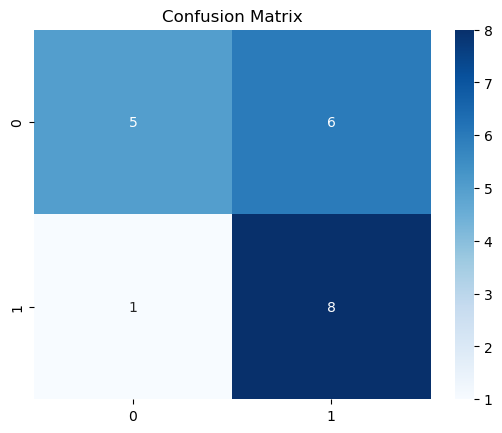

In [10]:
# Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()